In [17]:
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import cartopy.crs as ccrs
import cartopy
import numpy as np
import matplotlib.pyplot as plt
import fiona

import fiona
import geopandas as gpd
from shapely.geometry import mapping

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
df = gpd.read_file('./East_River.kml', driver='KML')
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (20, 20)

In [2]:
def get_narr_precip(year):
    urlpath =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/apcp.{year}.nc"
    ds = xr.open_dataset(urlpath,decode_coords="all")
    return ds

In [3]:
def plotMap():
    # adapted from https://www.guillaumedueymes.com/post/narr_synoptic/
    #Set the projection information
    proj = ccrs.LambertConformal(central_longitude=-100.0,central_latitude=53, standard_parallels=[53])
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    #Zoom in
    ax.set_extent([-130,-70,20,60]);
    
    #Add map features
    ax.add_feature(cartopy.feature.LAND, facecolor='0.9'); #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.9);  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cartopy.feature.BORDERS, zorder=10);
    ax.add_feature(cartopy.feature.COASTLINE, zorder=10);


    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none');
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10);
    
    #Add lat/lon gridlines every 20° to the map
    ax.gridlines(xlocs=np.arange(0,361,20), ylocs=np.arange(-80,90,20));
    
    return fig, ax

In [4]:
# from matplotlib.colors import LinearSegmentedColormap

# fig, ax = plotMap()
# cmap0 = plt.get_cmap('Blues',10).copy()

# ax.contourf(test.lon.values, test.lon.values, test.apcp.values,transform = ccrs.PlateCarree(), cmap=cmap0, zorder=2)

In [36]:


annual_precip = get_narr_precip(2021).isel(time=8)
annual_precip = xr.DataArray(data=annual_precip.apcp.values,
            dims=['x','y'],
            coords = dict(
                lon=(["x","y"],annual_precip.lon.values),
                lat=(["x","y"],annual_precip.lat.values),
            )
)
annual_precip.name='apcp'
annual_precip.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
annual_precip.rio.write_crs("epsg:4326", inplace=True)
east_river_polygon = gpd.read_file("./East_River.kml", driver='KML', crs="epsg:4326")

clipped = annual_precip.rio.clip(east_river_polygon.geometry.apply(mapping), east_river_polygon.crs, drop=False)

In [39]:
clipped

<xarray.DataArray 'apcp' (x: 277, y: 349)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lon          (x, y) float32 -145.5 -145.3 -145.1 ... -2.718 -2.644 -2.57
    lat          (x, y) float32 1.0 1.104 1.208 1.312 ... 46.93 46.64 46.35
    spatial_ref  int32 0
Dimensions without coordinates: x, y

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

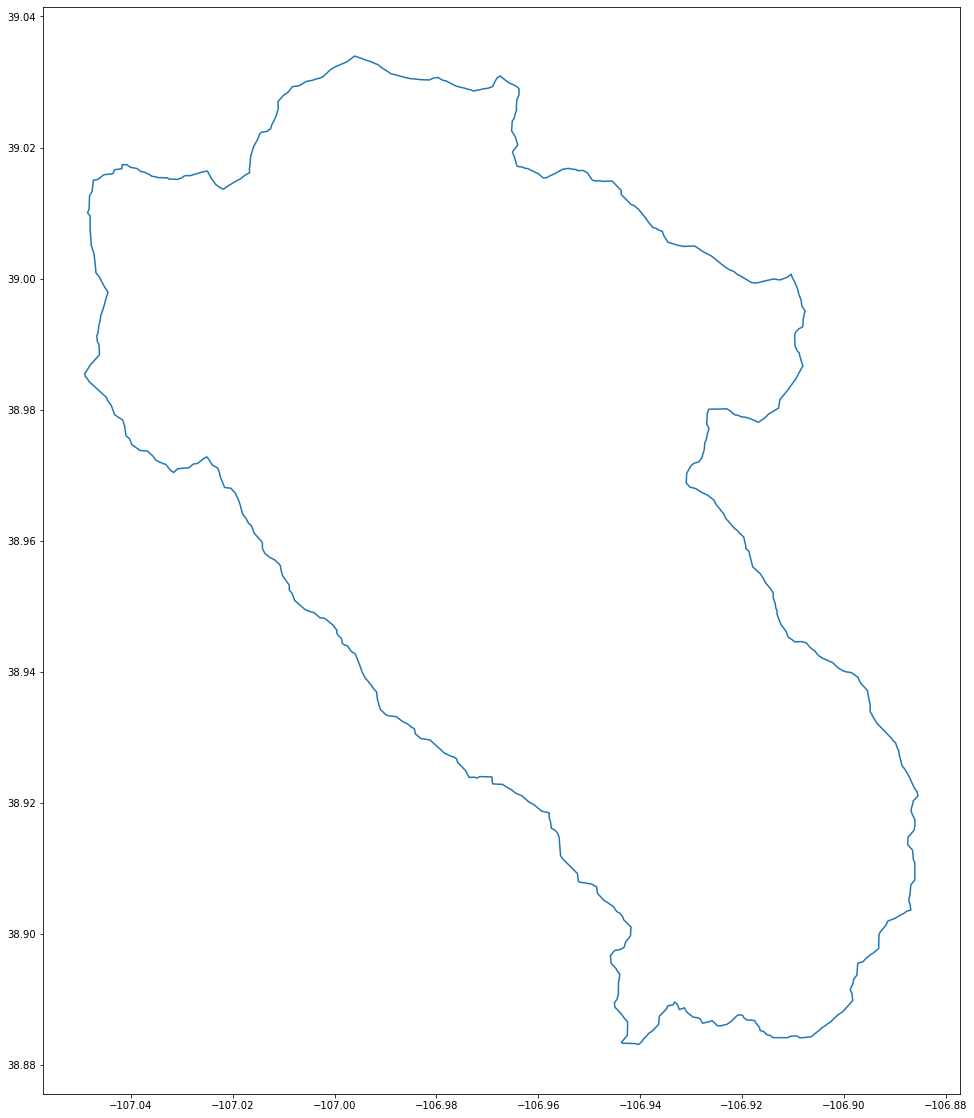

In [43]:

east_river_polygon.boundary.plot()
plt.contourf(clipped.lon.values, clipped.lon.values, clipped.values,transform = ccrs.PlateCarree(), zorder=2)

In [32]:

data_crs = ccrs.LambertConformal(central_longitude=-107.0,central_latitude=50)
x,y = data_crs.transform_point(-107, 38,src_crs=ccrs.PlateCarree())
test.drop_dims('nbnds').sel(x=x,y=y, method='nearest')

NameError: name 'test' is not defined

In [15]:
import fiona
import geopandas as gpd

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

east_river_polygon = gpd.read_file("./East_River.kml", driver='KML')

AttributeError: 'NoneType' object has no attribute 'drvsupport'

In [49]:
ds = get_narr_precip(2021).drop_dims('nbnds')
proj = ccrs.LambertConformal(central_longitude=-107.0,central_latitude=50, standard_parallels=[50])
ds_rio = ds.apcp.rio.write_crs(proj, inplace=True)
ds_rio

<xarray.DataArray 'apcp' (time: 365, y: 277, x: 349)>
[35285645 values with dtype=float32]
Coordinates:
  * time               (time) datetime64[ns] 2021-01-01 ... 2021-12-31
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
    Lambert_Conformal  int32 0
Attributes:
    GRIB_id:        61
    GRIB_name:      APCP
    level_desc:     Surface
    standard_name:  precipitation_amount
    units:          kg/m^2
    var_desc:       Precipitation amount
    dataset:        NARR Daily Sums
    long_name:      Daily accumulated total precipitation at Surface
    parent_stat:    Individual Obs
    statistic:      Sum
    valid_range:    [  0. 800.]
    actual_range:   [  0.      251.50156]
    _ChunkSizes:    [  1 277 349]

In [51]:
# clip and plot

from shapely.geometry import mapping, Polygon
clipped1 = ds_rio.rio.clip(east_river_polygon.geometry.apply(mapping), east_river_polygon.crs, drop=False, invert=False)     # clips everything - all nan
clipped2 = ds_rio.rio.clip(east_river_polygon.geometry.apply(mapping), east_river_polygon.crs, drop=False, invert=True)      # clips nothing

plottime='2021-08-01'
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(211,projection=ccrs.PlateCarree())
clipped1.sel(time=plottime).plot(ax=ax1)
east_river_polygon.boundary.plot(ax=ax1,color='black')
plt.title("clipped pr invert=False")

plt.show()

In [241]:
test_data_array = xr.DataArray(data=test.apcp.values,
            dims=['x','y'],
            coords = dict(
                lon=(["x","y"],test.lon.values),
                lat=(["x","y"],test.lat.values)
            )
)



In [243]:
test_data_array.sel(x=2, y=2)

<xarray.DataArray ()>
array(7.073036, dtype=float32)
Coordinates:
    lon      float32 -137.9
    lat      float32 18.39